In [1]:
# https://udemy.com/recommender-systems
# https://deeplearningcourses.com/recommender-systems
from __future__ import print_function, division
from builtins import range, input
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

# load in the data
df = pd.read_csv('large_files/movielens-20m-dataset/edited_rating.csv')

N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
#reg = 0.1 # regularization penalty

Using TensorFlow backend.
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\d

In [2]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)

#vamos combinar fatorizacao de matrizes(main) com deep neural network,(side) como a MF é linear a DNN trabalha apartir do 
#residuo/erro/ruido(valor correto-previsao) para tentar achar padroes nao lineares

##### main branch (MF)
u_bias = Embedding(N, 1)(u) # (N, 1, 1)
m_bias = Embedding(M, 1)(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)


##### side branch (DNN)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
y = Concatenate()([u_embedding, m_embedding]) # (N, 2K)
y = Dense(400)(y)
y = Activation('relu')(y)
# y = Dropout(0.5)(y)
y = Dense(1)(y)


##### merge (x=MF y=DNN)
x = Add()([x, y])

In [3]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movie_idx.values],
    df_test.rating.values - mu
  )
)


Train on 16000210 samples, validate on 4000053 samples
Epoch 1/15
16000210/16000210 [==============================] - 533s 33us/step - loss: 0.7428 - mse: 0.7428 - val_loss: 0.6965 - val_mse: 0.6965
Epoch 2/15
16000210/16000210 [==============================] - 533s 33us/step - loss: 0.6690 - mse: 0.6690 - val_loss: 0.6598 - val_mse: 0.6598
Epoch 3/15
16000210/16000210 [==============================] - 535s 33us/step - loss: 0.6294 - mse: 0.6294 - val_loss: 0.6399 - val_mse: 0.6399
Epoch 4/15
16000210/16000210 [==============================] - 534s 33us/step - loss: 0.6015 - mse: 0.6015 - val_loss: 0.6313 - val_mse: 0.6313
Epoch 5/15
16000210/16000210 [==============================] - 537s 34us/step - loss: 0.5841 - mse: 0.5841 - val_loss: 0.6357 - val_mse: 0.6357
Epoch 6/15
16000210/16000210 [==============================] - 534s 33us/step - loss: 0.5732 - mse: 0.5732 - val_loss: 0.6260 - val_mse: 0.6260
Epoch 7/15
16000210/16000210 [==============================] - 531s 33us/

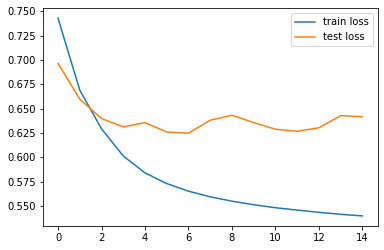

In [4]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

In [5]:
# plot mse
#plt.plot(r.history['mse'], label="train mse")
#plt.plot(r.history['val_mse'], label="test mse")
#plt.legend()
#plt.show()